# 🛣️ Road Lane Detection (Google Colab Compatible)
This notebook detects lane lines from a video using OpenCV and safely handles all drawing operations.

In [1]:
# 🔧 Install required libraries
!pip install opencv-python numpy

In [ ]:
# 📁 Upload a video file
from google.colab import files
uploaded = files.upload()

In [3]:
import cv2
import numpy as np
from PIL import Image
from IPython.display import display, clear_output

def canny_edge_detector(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blur, 50, 150)
    return edges

def region_of_interest(image):
    height = image.shape[0]
    polygons = np.array([[(100, height), (image.shape[1]-100, height), (image.shape[1]//2, height//2 + 50)]])
    mask = np.zeros_like(image)
    cv2.fillPoly(mask, polygons, 255)
    return cv2.bitwise_and(image, mask)

def make_coordinates(image, line_parameters):
    try:
        slope, intercept = line_parameters
        if slope == 0 or np.isnan(slope) or np.isnan(intercept) or np.isinf(slope) or np.isinf(intercept):
            return None
        y1 = image.shape[0]
        y2 = int(y1 * 0.6)
        x1 = int((y1 - intercept) / slope)
        x2 = int((y2 - intercept) / slope)
        return [x1, y1, x2, y2]
    except:
        return None

def average_slope_intercept(image, lines):
    left, right = [], []
    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
        if x2 - x1 == 0:
            continue
        parameters = np.polyfit((x1, x2), (y1, y2), 1)
        slope, intercept = parameters
        if slope < 0:
            left.append((slope, intercept))
        else:
            right.append((slope, intercept))
    output_lines = []
    if left:
        left_avg = np.average(left, axis=0)
        left_line = make_coordinates(image, left_avg)
        if left_line is not None:
            output_lines.append(left_line)
    if right:
        right_avg = np.average(right, axis=0)
        right_line = make_coordinates(image, right_avg)
        if right_line is not None:
            output_lines.append(right_line)
    return output_lines

def display_lines(image, lines):
    line_image = np.zeros_like(image)
    if lines is not None:
        for line in lines:
            if line and len(line) == 4:
                try:
                    x1 = int(float(line[0]))
                    y1 = int(float(line[1]))
                    x2 = int(float(line[2]))
                    y2 = int(float(line[3]))
                    cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 10)
                except Exception as e:
                    print("⚠️ Line skipped due to error:", e)
    return line_image

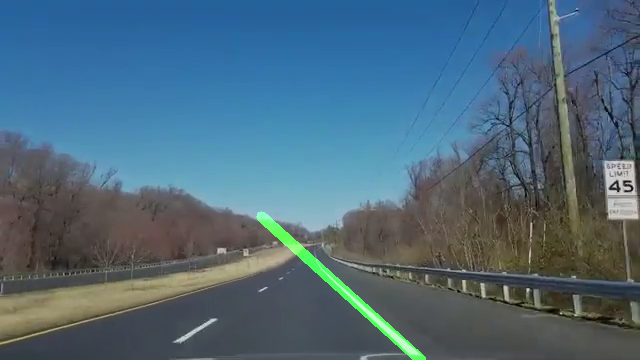

In [4]:
# ▶️ Run Lane Detection on Video (in Colab-compatible way)
input_video = list(uploaded.keys())[0]
cap = cv2.VideoCapture(input_video)

frame_count = 0
while cap.isOpened() and frame_count < 100:
    ret, frame = cap.read()
    if not ret:
        break

    canny = canny_edge_detector(frame)
    cropped = region_of_interest(canny)
    lines = cv2.HoughLinesP(cropped, 2, np.pi / 180, 100, np.array([]), minLineLength=40, maxLineGap=5)
    if lines is not None:
        avg_lines = average_slope_intercept(frame, lines)
        line_img = display_lines(frame, avg_lines)
        combo = cv2.addWeighted(frame, 0.8, line_img, 1, 1)
    else:
        combo = frame

    rgb = cv2.cvtColor(combo, cv2.COLOR_BGR2RGB)
    display(Image.fromarray(rgb))
    clear_output(wait=True)
    frame_count += 1

cap.release()